In [ ]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [ ]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)

    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate

    Outputs:
    --------
    u_sample: generated u(·) profiles
    """

    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1)

    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior

    return u_sample

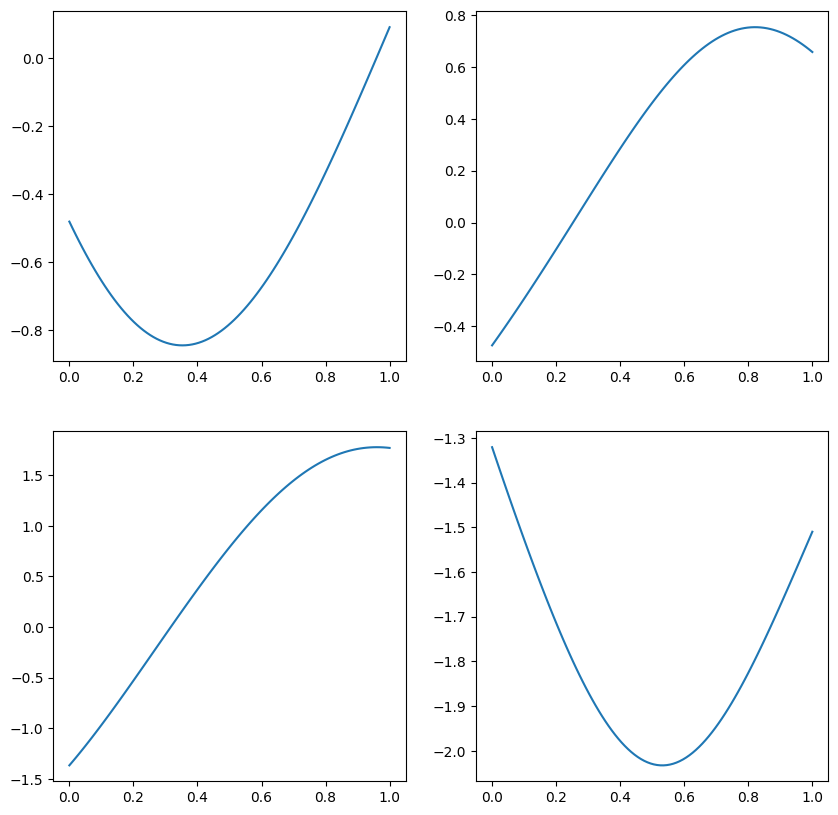

In [ ]:
# Inspect generated data
length_scale = 0.6
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1)
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

In [ ]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.

    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)

    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """

    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)

    return X, y

In [ ]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 355.38it/s]


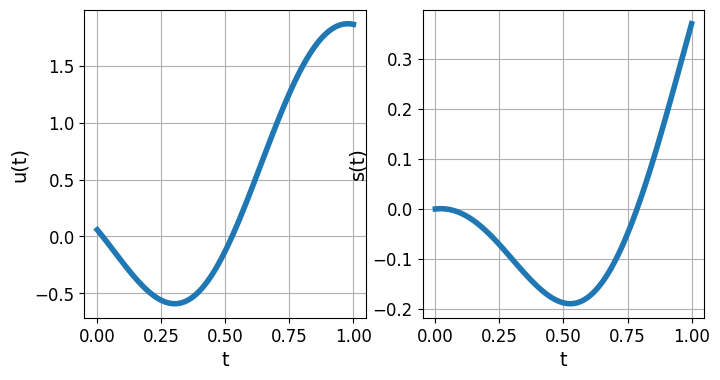

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

In [ ]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

In [ ]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

In [ ]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

In [ ]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})

    # Calculate gradients
    ds_dt = tape.gradient(s, t)

    # ODE residual
    ODE_residual = ds_dt - u_t

    return ODE_residual

In [ ]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

In [ ]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

In [ ]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init,
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")

        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1],
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=3.8970e-02,               ODE=2.0146e-01,               total_loss=2.4043e-01
1/1 [==============================] - 0s 217ms/step
val_IC: 5.5826e-03, val_ODE: 5.0283e-02, lr: 1.00e-03
1/1 [==============================] - 0s 60ms/step
RMSE: 0.08303197772880258


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 2:
IC=3.9450e-03,               ODE=3.7461e-02,               total_loss=4.1406e-02
1/1 [==============================] - 0s 25ms/step
val_IC: 2.1435e-03, val_ODE: 3.0704e-02, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0649783381474408
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3:
IC=2.1322e-03,               ODE=2.3811e-02,               total_loss=2.5944e-02
1/1 [==============================] - 0s 22ms/step
val_IC: 1.2324e-03, val_ODE: 2.1467e-02, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.04935908967344729
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4:
IC=1.4134e-03,               ODE=1.7104e-02,               total_loss=1.8517e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0534e-03, val_ODE: 1.6026e-02, lr: 1.00e-03
1/1 [==============================] - 0s 48ms/step
RMSE: 0.038937164278839205
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5:
IC=9.8934e-04,               ODE=1.3409e-02,               total_loss=1.4399e-02
1/1 [==============================] - 0s 24ms/step
val_IC: 1.0921e-03, val_ODE: 1.3719e-02, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.03140705031726334
1/1 [==============================] - 0s 22ms/step
Epoch 6:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0044e-04,               ODE=1.0479e-02,               total_loss=1.1180e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 5.7254e-04, val_ODE: 9.0484e-03, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.026127207944579848
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7:
IC=5.6470e-04,               ODE=7.4748e-03,               total_loss=8.0395e-03
1/1 [==============================] - 0s 33ms/step
val_IC: 3.0573e-04, val_ODE: 5.9018e-03, lr: 1.00e-03
1/1 [==============================] - 0s 66ms/step
RMSE: 0.021991093460657776


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 40ms/step
Epoch 8:
IC=4.6589e-04,               ODE=5.1140e-03,               total_loss=5.5798e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 2.4315e-04, val_ODE: 4.5458e-03, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.021393560534156083
1/1 [==============================] - 0s 21ms/step
Epoch 9:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7356e-04,               ODE=3.9694e-03,               total_loss=4.3430e-03
1/1 [==============================] - 0s 26ms/step
val_IC: 2.3191e-04, val_ODE: 3.9441e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.019171984897387882
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
Epoch 10:
IC=3.0709e-04,               ODE=3.4859e-03,               total_loss=3.7929e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.2875e-04, val_ODE: 3.7265e-03, lr: 1.00e-03
1/1 [==============================] - 0s 45ms/step
RMSE: 0.018198742521283905
1/1 [==============================] - 0s 24ms/step
Epoch 11:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8341e-04,               ODE=3.2515e-03,               total_loss=3.5349e-03
1/1 [==============================] - 0s 32ms/step
val_IC: 2.5515e-04, val_ODE: 3.6939e-03, lr: 1.00e-03
1/1 [==============================] - 0s 56ms/step
RMSE: 0.023496226446653168


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 12:
IC=2.5935e-04,               ODE=3.0748e-03,               total_loss=3.3342e-03
1/1 [==============================] - 0s 28ms/step
val_IC: 1.8662e-04, val_ODE: 3.2229e-03, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.018580814868169336
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13:
IC=2.6920e-04,               ODE=2.9649e-03,               total_loss=3.2341e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 2.5915e-04, val_ODE: 3.5757e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.01608222910414843
1/1 [==============================] - 0s 22ms/step
Epoch 14:
IC=2.1930e-04,               ODE=2.7345e-03,               total_loss=2.9538e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1005e-04, val_ODE: 2.9159e-03, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.01751695464994474
1/1 [==============================] - 0s 22ms/step
Epoch 15:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4811e-04,               ODE=3.0005e-03,               total_loss=3.2486e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 1.1049e-04, val_ODE: 2.5706e-03, lr: 1.00e-03
1/1 [==============================] - 0s 45ms/step
RMSE: 0.013611623775238963
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 16:
IC=1.8859e-04,               ODE=2.4655e-03,               total_loss=2.6541e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 1.3576e-04, val_ODE: 3.7151e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.019874845521380143
1/1 [==============================] - 0s 21ms/step
Epoch 17:
IC=1.9317e-04,               ODE=2.6636e-03,               total_loss=2.8568e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 6.0355e-05, val_ODE: 2.7776e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.019954793463660272
1/1 [==============================] - 0s 23ms/step
Epoch 18:
IC=1.8117e-04,               ODE=2.4214e-03,               total_loss=2.6026e-03
1/1 [==============================] - 0s 29ms/step
val_IC: 8.7539e-05, val_ODE: 2.8218e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.01423738985605787
1/1 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3538e-04,               ODE=2.0711e-03,               total_loss=2.2064e-03
1/1 [==============================] - 0s 27ms/step
val_IC: 5.6999e-05, val_ODE: 1.8586e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.012949603353376733
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21:
IC=1.2498e-04,               ODE=2.2610e-03,               total_loss=2.3860e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.7284e-04, val_ODE: 2.1064e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.014079026285287956
1/1 [==============================] - 0s 24ms/step
Epoch 22:
IC=1.1982e-04,               ODE=1.8649e-03,               total_loss=1.9847e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1239e-04, val_ODE: 1.6093e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.010549837467577972
1/1 [==============================] - 0s 22ms/step
Epoch 23:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8162e-04,               ODE=2.3948e-03,               total_loss=2.5764e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 1.2961e-04, val_ODE: 1.9500e-03, lr: 1.00e-03
1/1 [==============================] - 0s 34ms/step
RMSE: 0.011269994827983482
1/1 [==============================] - 0s 25ms/step
Epoch 24:
IC=1.3016e-04,               ODE=1.8117e-03,               total_loss=1.9419e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 6.7646e-05, val_ODE: 2.9525e-03, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.02182328050091356
1/1 [==============================] - 0s 21ms/step
Epoch 25:
IC=9.9702e-05,               ODE=1.8144e-03,               total_loss=1.9141e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0745e-04, val_ODE: 2.2165e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.019970173478073328
1/1 [==============================] - 0s 24ms/step
Epoch 26:
IC=1.0294e-04,   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.012832496591361741
1/1 [==============================] - 0s 43ms/step
Epoch 29:
IC=9.9131e-05,               ODE=1.4824e-03,               total_loss=1.5815e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1796e-04, val_ODE: 2.1989e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.013176242319679354
1/1 [==============================] - 0s 21ms/step
Epoch 30:
IC=1.3592e-04,               ODE=1.7844e-03,               total_loss=1.9204e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.8323e-04, val_ODE: 1.2023e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.012565596578195115
1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 31:
IC=9.4055e-05,               ODE=1.3967e-03,               total_loss=1.4908e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 3.2597e-05, val_ODE: 1.0027e-03, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.011976897283113493


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 32:
IC=1.0233e-04,               ODE=1.3874e-03,               total_loss=1.4897e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 7.0360e-05, val_ODE: 1.6189e-03, lr: 1.00e-03
1/1 [==============================] - 0s 34ms/step
RMSE: 0.01549055492603318
1/1 [==============================] - 0s 23ms/step
Epoch 33:
IC=1.2690e-04,               ODE=1.5143e-03,               total_loss=1.6412e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 9.2098e-05, val_ODE: 1.0400e-03, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.010074567859691241
1/1 [==============================] - 0s 23ms/step
Epoch 34:
IC=8.3551e-05,               ODE=1.2613e-03,               total_loss=1.3449e-03
1/1 [==============================] - 0s 25ms/step
val_IC: 1.0814e-04, val_ODE: 1.3200e-03, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.012091375457060918
1/1 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6633e-05,               ODE=1.0661e-03,               total_loss=1.1528e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 4.9761e-05, val_ODE: 6.2478e-04, lr: 1.00e-03
1/1 [==============================] - 0s 39ms/step
RMSE: 0.008820694127576939
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 37:
IC=8.6891e-05,               ODE=1.2328e-03,               total_loss=1.3197e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 6.5018e-05, val_ODE: 8.4397e-04, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.010288429771130052
1/1 [==============================] - 0s 22ms/step
Epoch 38:
IC=6.8110e-05,               ODE=8.5008e-04,               total_loss=9.1819e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.2384e-05, val_ODE: 1.1157e-03, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.017949939264150613
1/1 [==============================] - 0s 25ms/step
Epoch 39:
IC=2.3401e-04,               ODE=1.4390e-03,               total_loss=1.6730e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 2.2733e-04, val_ODE: 7.1424e-04, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.012270869611816601
1/1 [==============================] - 0s 23ms/step
Epoch 40:
IC=8.4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 41:
IC=6.1800e-05,               ODE=8.4551e-04,               total_loss=9.0731e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 5.5607e-05, val_ODE: 4.7723e-04, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.00883075606137745
1/1 [==============================] - 0s 21ms/step
Epoch 42:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7234e-05,               ODE=8.0028e-04,               total_loss=8.4752e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 5.7897e-05, val_ODE: 6.5651e-04, lr: 1.00e-03
1/1 [==============================] - 0s 34ms/step
RMSE: 0.010867580642225195
1/1 [==============================] - 0s 24ms/step
Epoch 43:
IC=6.4421e-05,               ODE=8.6236e-04,               total_loss=9.2678e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.7238e-05, val_ODE: 8.0618e-04, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.010470035938945486
1/1 [==============================] - 0s 22ms/step
Epoch 44:
IC=5.4409e-05,               ODE=8.6874e-04,               total_loss=9.2315e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 5.3456e-05, val_ODE: 6.2462e-04, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.009009016510696743
1/1 [==============================] - 0s 25ms/step
Epoch 45:
IC=5.2445e-05,  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 46:
IC=6.8731e-05,               ODE=9.5255e-04,               total_loss=1.0213e-03
1/1 [==============================] - 0s 33ms/step
val_IC: 6.8062e-05, val_ODE: 9.0612e-04, lr: 1.00e-03
1/1 [==============================] - 0s 64ms/step
RMSE: 0.014863709735897814
1/1 [==============================] - 0s 32ms/step
Epoch 47:
IC=8.3695e-05,               ODE=1.1786e-03,               total_loss=1.2623e-03
1/1 [==============================] - 0s 26ms/step
val_IC: 2.8957e-05, val_ODE: 9.2421e-04, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.009370875473709836
1/1 [==============================] - 0s 22ms/step
Epoch 48:
IC=6.2262e-05,               ODE=7.2475e-04,               total_loss=7.8702e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.6298e-05, val_ODE: 6.1120e-04, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.009155009835744181
1/1 [==============================] - 0s 21ms/step
Epoch 49:
IC=7.7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step
Epoch 55:
IC=4.7674e-05,               ODE=5.0470e-04,               total_loss=5.5237e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.7398e-05, val_ODE: 5.1639e-04, lr: 1.00e-03
1/1 [==============================] - 0s 36ms/step
RMSE: 0.007754891026986041
1/1 [==============================] - 0s 21ms/step
Epoch 56:
IC=4.4491e-05,               ODE=8.7203e-04,               total_loss=9.1652e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.5139e-05, val_ODE: 3.7827e-04, lr: 1.00e-03
1/1 [==============================] - 0s 37ms/step
RMSE: 0.005763367997908943
1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 57:
IC=3.9079e-05,               ODE=7.3665e-04,               total_loss=7.7573e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.8498e-05, val_ODE: 5.3286e-04, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 0.009992933636492273
1/1 [==============================] - 0s 24ms/step
Epoch 58:
IC=5.1569e-05,               ODE=6.8005e-04,               total_loss=7.3162e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.1379e-05, val_ODE: 3.6335e-04, lr: 1.00e-03
1/1 [==============================] - 0s 38ms/step
RMSE: 0.01061815705210952
1/1 [==============================] - 0s 24ms/step
Epoch 59:
IC=4.3605e-05,               ODE=5.8995e-04,               total_loss=6.3356e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.8141e-05, val_ODE: 8.2359e-04, lr: 1.00e-03
1/1 [==============================] - 0s 34ms/step
RMSE: 0.012376417670479143
1/1 [==============================] - 0s 21ms/step
Epoch 60:
IC=2.18

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 65:
IC=2.3399e-05,               ODE=5.2313e-04,               total_loss=5.4653e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 1.0932e-05, val_ODE: 7.8765e-04, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.005648034479291435
1/1 [==============================] - 0s 24ms/step
Epoch 66:
IC=7.0233e-05,               ODE=8.4548e-04,               total_loss=9.1572e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 1.1051e-05, val_ODE: 7.5520e-04, lr: 1.00e-03
1/1 [==============================] - 0s 42ms/step
RMSE: 0.00729205420047106
1/1 [==============================] - 0s 32ms/step
Epoch 67:
IC=4.2081e-05,               ODE=7.2422e-04,               total_loss=7.6630e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 9.4549e-05, val_ODE: 8.0041e-04, lr: 1.00e-03
1/1 [==============================] - 0s 35ms/step
RMSE: 0.008116528635071302
1/1 [==============================] - 0s 22ms/step
Epoch 68:
IC=7.15

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 77:
IC=9.5122e-06,               ODE=2.0881e-04,               total_loss=2.1832e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 9.7425e-06, val_ODE: 2.0868e-04, lr: 5.00e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0043725313856278775
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 78:
IC=9.6639e-06,               ODE=2.0143e-04,               total_loss=2.1110e-04
1/1 [==============================] - 0s 31ms/step
val_IC: 5.2308e-06, val_ODE: 1.9888e-04, lr: 5.00e-04
1/1 [==============================] - 0s 56ms/step
RMSE: 0.003793191312188951


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 32ms/step
Epoch 79:
IC=7.4592e-06,               ODE=1.9329e-04,               total_loss=2.0075e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.7658e-06, val_ODE: 1.8708e-04, lr: 5.00e-04
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0037999028038496114
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 80:
IC=7.4870e-06,               ODE=1.9339e-04,               total_loss=2.0087e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0686e-05, val_ODE: 1.8928e-04, lr: 5.00e-04
1/1 [==============================] - 0s 36ms/step
RMSE: 0.004001000948339743
1/1 [==============================] - 0s 26ms/step
Epoch 81:
IC=9.2260e-06,               ODE=1.9588e-04,               total_loss=2.0511e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 7.4390e-06, val_ODE: 1.9193e-04, lr: 5.00e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.004100671599119132
1/1 [==============================] - 0s 21ms/step
Epoch 82:
IC=7.2268e-06,               ODE=2.0202e-04,               total_loss=2.0925e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 8.4666e-06, val_ODE: 2.0642e-04, lr: 5.00e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.005096327434335131
1/1 [==============================] - 0s 23ms/step
Epoch 83:
IC=7.2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.1338e-06,               ODE=2.6351e-04,               total_loss=2.7165e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.3423e-06, val_ODE: 2.0842e-04, lr: 5.00e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.004521836753403314
1/1 [==============================] - 0s 21ms/step
Epoch 86:
IC=1.6324e-05,               ODE=2.7271e-04,               total_loss=2.8903e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.3910e-06, val_ODE: 2.6763e-04, lr: 5.00e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0045530179634893034
1/1 [==============================] - 0s 23ms/step
Epoch 87:
IC=1.3193e-05,               ODE=3.3357e-04,               total_loss=3.4676e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 3.8105e-05, val_ODE: 5.4255e-04, lr: 5.00e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.007192175134856205
1/1 [==============================] - 0s 26ms/step
Epoch 88:
IC=1.3951e-05, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9072e-05,               ODE=2.8336e-04,               total_loss=3.0243e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.5291e-05, val_ODE: 2.1420e-04, lr: 5.00e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0047717627898756585
1/1 [==============================] - 0s 24ms/step
Epoch 106:
IC=1.5779e-05,               ODE=2.5378e-04,               total_loss=2.6956e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.2619e-05, val_ODE: 2.4253e-04, lr: 5.00e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.006697830245352079
1/1 [==============================] - 0s 25ms/step
Epoch 107:
IC=5.9284e-06,               ODE=1.5592e-04,               total_loss=1.6185e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.2807e-06, val_ODE: 1.4444e-04, lr: 2.50e-04
1/1 [==============================] - 0s 38ms/step
RMSE: 0.002868832674421952
1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 108:
IC=4.1483e-06,               ODE=1.4731e-04,               total_loss=1.5146e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.3349e-06, val_ODE: 1.4812e-04, lr: 2.50e-04
1/1 [==============================] - 0s 38ms/step
RMSE: 0.003366266705203963
1/1 [==============================] - 0s 26ms/step
Epoch 109:
IC=5.4156e-06,               ODE=1.4704e-04,               total_loss=1.5246e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.2972e-06, val_ODE: 1.5081e-04, lr: 2.50e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.003584468619061272
1/1 [==============================] - 0s 23ms/step
Epoch 110:
IC=4.4623e-06,               ODE=1.4452e-04,               total_loss=1.4898e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.1327e-06, val_ODE: 1.4230e-04, lr: 2.50e-04
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0030956407850359757
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 111:
IC=4.1553e-06,               ODE=1.4329e-04,               total_loss=1.4745e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.1884e-06, val_ODE: 1.5628e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0035025273851882243
1/1 [==============================] - 0s 21ms/step
Epoch 112:
IC=5.5975e-06,               ODE=1.4643e-04,               total_loss=1.5203e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.8680e-06, val_ODE: 1.4417e-04, lr: 2.50e-04
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0031106479971084954
1/1 [==============================] - 0s 23ms/step
Epoch 113:
IC=3.9939e-06,               ODE=1.4049e-04,               total_loss=1.4449e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.7201e-06, val_ODE: 1.3594e-04, lr: 2.50e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0027541483873542287
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 114:
IC=3.8259e-06,               ODE=1.4645e-04,               total_loss=1.5028e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.3889e-06, val_ODE: 1.6445e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0031741251970334636
1/1 [==============================] - 0s 22ms/step
Epoch 115:
IC=4.8336e-06,               ODE=1.4710e-04,               total_loss=1.5194e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.3862e-06, val_ODE: 1.4333e-04, lr: 2.50e-04
1/1 [==============================] - 0s 36ms/step
RMSE: 0.003002727013672523
1/1 [==============================] - 0s 23ms/step
Epoch 116:
IC=4.9781e-06,               ODE=1.5303e-04,               total_loss=1.5801e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 2.6621e-06, val_ODE: 1.3192e-04, lr: 2.50e-04
1/1 [==============================] - 0s 56ms/step
RMSE: 0.0029983818264940603


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step
Epoch 117:
IC=5.7594e-06,               ODE=1.4752e-04,               total_loss=1.5328e-04
1/1 [==============================] - 0s 35ms/step
val_IC: 5.0346e-06, val_ODE: 1.7312e-04, lr: 2.50e-04
1/1 [==============================] - 0s 62ms/step
RMSE: 0.003493197729866848
1/1 [==============================] - 0s 34ms/step
Epoch 118:
IC=4.4931e-06,               ODE=1.7316e-04,               total_loss=1.7765e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 4.6330e-06, val_ODE: 2.8979e-04, lr: 2.50e-04
1/1 [==============================] - 0s 38ms/step
RMSE: 0.006091059070179828
1/1 [==============================] - 0s 22ms/step
Epoch 119:
IC=6.1127e-06,               ODE=1.6483e-04,               total_loss=1.7095e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 5.7469e-06, val_ODE: 2.2698e-04, lr: 2.50e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.005990688547474058
1/1 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.5359e-06,               ODE=1.9323e-04,               total_loss=2.0177e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 8.5207e-06, val_ODE: 1.6089e-04, lr: 2.50e-04
1/1 [==============================] - 0s 36ms/step
RMSE: 0.005947858415779453
1/1 [==============================] - 0s 21ms/step
Epoch 129:
IC=7.5833e-06,               ODE=1.5729e-04,               total_loss=1.6487e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.8237e-06, val_ODE: 1.6609e-04, lr: 2.50e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0034822367614767724
1/1 [==============================] - 0s 21ms/step
Epoch 130:
IC=5.1527e-06,               ODE=1.6993e-04,               total_loss=1.7508e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.8489e-06, val_ODE: 1.2463e-04, lr: 2.50e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 0.002332481380486917
1/1 [==============================] - 0s 21ms/step
Epoch 131:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2783e-06,               ODE=1.4025e-04,               total_loss=1.4453e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.9410e-06, val_ODE: 1.7293e-04, lr: 2.50e-04
1/1 [==============================] - 0s 32ms/step
RMSE: 0.0030976914383431917
1/1 [==============================] - 0s 22ms/step
Epoch 132:
IC=5.7403e-06,               ODE=1.7219e-04,               total_loss=1.7793e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.3569e-06, val_ODE: 1.5974e-04, lr: 2.50e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.003422162355970462
1/1 [==============================] - 0s 24ms/step
Epoch 133:
IC=6.3373e-06,               ODE=1.5215e-04,               total_loss=1.5848e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 4.4140e-06, val_ODE: 1.5475e-04, lr: 2.50e-04
1/1 [==============================] - 0s 61ms/step
RMSE: 0.004652066831390265
1/1 [==============================] - 0s 34ms/step
Epoch 134:
IC=6.3099e-0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 139:
IC=5.4958e-06,               ODE=1.3571e-04,               total_loss=1.4121e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 5.8055e-06, val_ODE: 1.5404e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0028465992592404386
1/1 [==============================] - 0s 21ms/step
Epoch 140:
IC=8.3625e-06,               ODE=1.7153e-04,               total_loss=1.7989e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.4008e-06, val_ODE: 1.5804e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.004587213019609117
1/1 [==============================] - 0s 23ms/step
Epoch 141:
IC=4.2407e-06,               ODE=1.5739e-04,               total_loss=1.6163e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.0287e-05, val_ODE: 1.2610e-04, lr: 2.50e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.004481509627757671
1/1 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 145:
IC=6.8548e-06,               ODE=1.9660e-04,               total_loss=2.0346e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.0872e-05, val_ODE: 1.5465e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.005034114191366033
1/1 [==============================] - 0s 20ms/step
Epoch 146:
IC=6.2165e-06,               ODE=1.5258e-04,               total_loss=1.5880e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.2011e-06, val_ODE: 1.4488e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0034189264795739154
1/1 [==============================] - 0s 23ms/step
Epoch 147:
IC=8.3047e-06,               ODE=1.3454e-04,               total_loss=1.4285e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.5723e-06, val_ODE: 1.1344e-04, lr: 2.50e-04
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0030844875254156827
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5747e-06,               ODE=1.3452e-04,               total_loss=1.4210e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.6500e-06, val_ODE: 1.7457e-04, lr: 2.50e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 0.004212228591969498
1/1 [==============================] - 0s 21ms/step
Epoch 149:
IC=1.0759e-05,               ODE=1.3428e-04,               total_loss=1.4504e-04
1/1 [==============================] - 0s 37ms/step
val_IC: 1.0476e-05, val_ODE: 1.3488e-04, lr: 2.50e-04
1/1 [==============================] - 0s 64ms/step
RMSE: 0.0030732814601731637
1/1 [==============================] - 0s 35ms/step
Epoch 150:
IC=4.8673e-06,               ODE=1.4782e-04,               total_loss=1.5269e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 2.2047e-06, val_ODE: 1.7274e-04, lr: 2.50e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0044482292719837885
1/1 [==============================] - 0s 21ms/step
Epoch 151:
IC=4.6494e-

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step
Epoch 154:
IC=4.8123e-06,               ODE=1.2817e-04,               total_loss=1.3298e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 6.7618e-06, val_ODE: 2.3593e-04, lr: 2.50e-04
1/1 [==============================] - 0s 39ms/step
RMSE: 0.004826311917678664
1/1 [==============================] - 0s 26ms/step
Epoch 155:
IC=6.3502e-06,               ODE=1.5425e-04,               total_loss=1.6060e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 8.4395e-06, val_ODE: 1.1781e-04, lr: 2.50e-04
1/1 [==============================] - 0s 49ms/step
RMSE: 0.0036440472962172123
1/1 [==============================] - 0s 21ms/step
Epoch 156:
IC=3.7721e-06,               ODE=1.2997e-04,               total_loss=1.3374e-04
1/1 [==============================] - 0s 30ms/step
val_IC: 4.8654e-06, val_ODE: 1.3420e-04, lr: 2.50e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.004092150785466205
1/1 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 42ms/step
Epoch 161:
IC=2.0636e-06,               ODE=8.1152e-05,               total_loss=8.3216e-05
1/1 [==============================] - 0s 28ms/step
val_IC: 1.7144e-06, val_ODE: 7.9814e-05, lr: 1.25e-04
1/1 [==============================] - 0s 44ms/step
RMSE: 0.00189289157152044


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 37ms/step
Epoch 162:
IC=1.9817e-06,               ODE=7.9801e-05,               total_loss=8.1783e-05
1/1 [==============================] - 0s 36ms/step
val_IC: 1.3931e-06, val_ODE: 9.2640e-05, lr: 1.25e-04
1/1 [==============================] - 0s 62ms/step
RMSE: 0.00241542404406543
1/1 [==============================] - 0s 37ms/step
Epoch 163:
IC=1.9230e-06,               ODE=7.9136e-05,               total_loss=8.1059e-05
1/1 [==============================] - 0s 28ms/step
val_IC: 1.7369e-06, val_ODE: 8.0672e-05, lr: 1.25e-04
1/1 [==============================] - 0s 46ms/step
RMSE: 0.00206502853401904
1/1 [==============================] - 0s 24ms/step
Epoch 164:
IC=2.1740e-06,               ODE=7.8682e-05,               total_loss=8.0856e-05
1/1 [==============================] - 0s 29ms/step
val_IC: 2.0364e-06, val_ODE: 7.7952e-05, lr: 1.25e-04
1/1 [==============================] - 0s 48ms/step
RMSE: 0.0024961933628948607


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 165:
IC=2.2374e-06,               ODE=7.8695e-05,               total_loss=8.0932e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 2.3398e-06, val_ODE: 8.3893e-05, lr: 1.25e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 0.002128118218871946
1/1 [==============================] - 0s 24ms/step
Epoch 166:
IC=2.5821e-06,               ODE=7.9754e-05,               total_loss=8.2337e-05
1/1 [==============================] - 0s 36ms/step
val_IC: 1.4896e-06, val_ODE: 8.1221e-05, lr: 1.25e-04
1/1 [==============================] - 0s 65ms/step
RMSE: 0.0018836677932160685
1/1 [==============================] - 0s 40ms/step
Epoch 167:
IC=2.2237e-06,               ODE=7.6333e-05,               total_loss=7.8556e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.5030e-06, val_ODE: 7.9754e-05, lr: 1.25e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0020282322900650367
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 67ms/step
RMSE: 0.002142547695866641
1/1 [==============================] - 0s 37ms/step
Epoch 170:
IC=2.4073e-06,               ODE=7.4547e-05,               total_loss=7.6954e-05
1/1 [==============================] - 0s 26ms/step
val_IC: 1.9002e-06, val_ODE: 8.7873e-05, lr: 1.25e-04
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0024832071818390333
1/1 [==============================] - 0s 32ms/step
Epoch 171:
IC=2.9751e-06,               ODE=8.2153e-05,               total_loss=8.5129e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.6562e-06, val_ODE: 7.9919e-05, lr: 1.25e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0022012942122394403
1/1 [==============================] - 0s 26ms/step
Epoch 172:
IC=2.8461e-06,               ODE=7.1418e-05,               total_loss=7.4264e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.8635e-07, val_ODE: 7.1843e-05, lr: 1.25e-04
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
Epoch 173:
IC=3.1081e-06,               ODE=7.3930e-05,               total_loss=7.7039e-05
1/1 [==============================] - 0s 27ms/step
val_IC: 1.6527e-06, val_ODE: 7.8194e-05, lr: 1.25e-04
1/1 [==============================] - 0s 46ms/step
RMSE: 0.003122685484182233
1/1 [==============================] - 0s 25ms/step
Epoch 174:
IC=2.8478e-06,               ODE=8.1012e-05,               total_loss=8.3859e-05
1/1 [==============================] - 0s 26ms/step
val_IC: 2.9374e-06, val_ODE: 1.5028e-04, lr: 1.25e-04
1/1 [==============================] - 0s 46ms/step
RMSE: 0.0050887816930813515
1/1 [==============================] - 0s 25ms/step
Epoch 175:
IC=3.1318e-06,               ODE=7.7883e-05,               total_loss=8.1015e-05
1/1 [==============================] - 0s 36ms/step
val_IC: 1.6415e-06, val_ODE: 7.1548e-05, lr: 1.25e-04
1/1 [==============================] - 0s 56ms/step
RMSE: 0.0018979518154631542
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 177:
IC=2.2705e-06,               ODE=8.0523e-05,               total_loss=8.2793e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9668e-06, val_ODE: 7.6412e-05, lr: 1.25e-04
1/1 [==============================] - 0s 50ms/step
RMSE: 0.0023616826834608005
1/1 [==============================] - 0s 23ms/step
Epoch 178:
IC=2.5894e-06,               ODE=8.0023e-05,               total_loss=8.2612e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 2.7239e-06, val_ODE: 7.1812e-05, lr: 1.25e-04
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0027401660275801743
1/1 [==============================] - 0s 21ms/step
Epoch 179:
IC=2.9536e-06,               ODE=7.7306e-05,               total_loss=8.0260e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 3.8423e-06, val_ODE: 9.2807e-05, lr: 1.25e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0022627305014230772
1/1 [==============================] - 0s 23ms/step
Epoch 180:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step
Epoch 181:
IC=2.3526e-06,               ODE=7.0061e-05,               total_loss=7.2414e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 4.0343e-06, val_ODE: 7.0872e-05, lr: 1.25e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0032249686974095077
1/1 [==============================] - 0s 24ms/step
Epoch 182:
IC=2.3863e-06,               ODE=7.7134e-05,               total_loss=7.9520e-05
1/1 [==============================] - 0s 27ms/step
val_IC: 1.3678e-06, val_ODE: 7.2595e-05, lr: 1.25e-04
1/1 [==============================] - 0s 35ms/step
RMSE: 0.003457560440372616
1/1 [==============================] - 0s 22ms/step
Epoch 183:
IC=3.3013e-06,               ODE=7.3880e-05,               total_loss=7.7181e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 2.5407e-06, val_ODE: 6.8673e-05, lr: 1.25e-04
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0024646830875285873
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4375e-06,               ODE=7.1653e-05,               total_loss=7.4090e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 3.3786e-06, val_ODE: 8.5851e-05, lr: 1.25e-04
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0025162533296949692
1/1 [==============================] - 0s 23ms/step
Epoch 189:
IC=2.4599e-06,               ODE=7.2276e-05,               total_loss=7.4736e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 4.9051e-06, val_ODE: 6.6926e-05, lr: 1.25e-04
1/1 [==============================] - 0s 33ms/step
RMSE: 0.003814414727515489
1/1 [==============================] - 0s 22ms/step
Epoch 190:
IC=2.7856e-06,               ODE=6.1353e-05,               total_loss=6.4139e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.9307e-06, val_ODE: 5.5950e-05, lr: 1.25e-04
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0021252276251506595
1/1 [==============================] - 0s 23ms/step
Epoch 191:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5056e-06,               ODE=4.9169e-05,               total_loss=5.0675e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 9.5182e-07, val_ODE: 5.4120e-05, lr: 6.25e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.00176314263182513


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 23ms/step
Epoch 192:
IC=1.5489e-06,               ODE=4.8658e-05,               total_loss=5.0207e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1267e-06, val_ODE: 5.0169e-05, lr: 6.25e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.001768829363649181
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 193:
IC=1.5030e-06,               ODE=4.8270e-05,               total_loss=4.9773e-05
1/1 [==============================] - 0s 31ms/step
val_IC: 1.1788e-06, val_ODE: 5.0313e-05, lr: 6.25e-05
1/1 [==============================] - 0s 55ms/step
RMSE: 0.0017389961122051027
1/1 [==============================] - 0s 33ms/step
Epoch 194:
IC=1.7354e-06,               ODE=4.7898e-05,               total_loss=4.9633e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1531e-06, val_ODE: 5.0131e-05, lr: 6.25e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0016635775108484474
1/1 [==============================] - 0s 22ms/step
Epoch 195:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5287e-06,               ODE=4.7170e-05,               total_loss=4.8699e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.7828e-06, val_ODE: 5.1249e-05, lr: 6.25e-05
1/1 [==============================] - 0s 32ms/step
RMSE: 0.001988147726831833
1/1 [==============================] - 0s 22ms/step
Epoch 196:
IC=1.5554e-06,               ODE=4.7173e-05,               total_loss=4.8729e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 1.1164e-06, val_ODE: 4.9942e-05, lr: 6.25e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0018590776680813522


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 35ms/step
Epoch 197:
IC=1.5950e-06,               ODE=4.8092e-05,               total_loss=4.9687e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2007e-06, val_ODE: 4.9502e-05, lr: 6.25e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.001856438507039859
1/1 [==============================] - 0s 21ms/step
Epoch 198:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5900e-06,               ODE=4.6501e-05,               total_loss=4.8091e-05
1/1 [==============================] - 0s 32ms/step
val_IC: 1.0455e-06, val_ODE: 5.2351e-05, lr: 6.25e-05
1/1 [==============================] - 0s 53ms/step
RMSE: 0.0018262606819556017
1/1 [==============================] - 0s 44ms/step
Epoch 199:
IC=1.6049e-06,               ODE=4.5883e-05,               total_loss=4.7488e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1528e-06, val_ODE: 4.8296e-05, lr: 6.25e-05
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0017387073562166457


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 200:
IC=1.6041e-06,               ODE=4.6535e-05,               total_loss=4.8140e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.2390e-06, val_ODE: 4.7474e-05, lr: 6.25e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0018433473939809288
1/1 [==============================] - 0s 21ms/step
Epoch 201:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0615e-06,               ODE=4.6198e-05,               total_loss=4.8259e-05
1/1 [==============================] - 0s 32ms/step
val_IC: 3.3446e-06, val_ODE: 5.2117e-05, lr: 6.25e-05
1/1 [==============================] - 0s 56ms/step
RMSE: 0.0026012742704843946
1/1 [==============================] - 0s 32ms/step
Epoch 202:
IC=1.5560e-06,               ODE=4.6270e-05,               total_loss=4.7826e-05
1/1 [==============================] - 0s 33ms/step
val_IC: 9.2195e-07, val_ODE: 4.6224e-05, lr: 6.25e-05
1/1 [==============================] - 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.002102195171920139
1/1 [==============================] - 0s 33ms/step
Epoch 203:
IC=1.5429e-06,               ODE=4.4522e-05,               total_loss=4.6065e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.3348e-06, val_ODE: 5.2837e-05, lr: 6.25e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0022289278778459868
1/1 [==============================] - 0s 21ms/step
Epoch 204:
IC=1.5260e-06,               ODE=4.5059e-05,               total_loss=4.6585e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 8.5979e-07, val_ODE: 4.6302e-05, lr: 6.25e-05
1/1 [==============================] - 0s 51ms/step
RMSE: 0.001979708885597739
1/1 [==============================] - 0s 34ms/step
Epoch 205:
IC=1.7977e-06,               ODE=4.5540e-05,               total_loss=4.7338e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.1297e-06, val_ODE: 5.9133e-05, lr: 6.25e-05
1/1 [==============================] - 0s 44ms/step
RMSE: 0.0019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 208:
IC=1.5825e-06,               ODE=4.3387e-05,               total_loss=4.4969e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 9.4744e-07, val_ODE: 4.7628e-05, lr: 6.25e-05
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0018732374594432168
1/1 [==============================] - 0s 22ms/step
Epoch 209:
IC=1.6663e-06,               ODE=4.4097e-05,               total_loss=4.5763e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 2.3476e-06, val_ODE: 4.2934e-05, lr: 6.25e-05
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0022183321618285314
1/1 [==============================] - 0s 23ms/step
Epoch 210:
IC=1.7392e-06,               ODE=4.2429e-05,               total_loss=4.4168e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.0740e-06, val_ODE: 4.3047e-05, lr: 6.25e-05
1/1 [==============================] - 0s 43ms/step
RMSE: 0.0017484262786952494
1/1 [==============================] - 0s 25ms/step
Epoch 211:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 214:
IC=1.5147e-06,               ODE=4.1990e-05,               total_loss=4.3505e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.4462e-06, val_ODE: 4.3162e-05, lr: 6.25e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0020084839362633374
1/1 [==============================] - 0s 24ms/step
Epoch 215:
IC=1.6061e-06,               ODE=4.2301e-05,               total_loss=4.3908e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.7252e-06, val_ODE: 4.6498e-05, lr: 6.25e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.001816306718589712
1/1 [==============================] - 0s 26ms/step
Epoch 216:
IC=1.4696e-06,               ODE=3.9387e-05,               total_loss=4.0857e-05
1/1 [==============================] - 0s 36ms/step
val_IC: 1.5264e-06, val_ODE: 4.0697e-05, lr: 6.25e-05
1/1 [==============================] - 0s 66ms/step
RMSE: 0.001861723702407674
1/1 [==============================] - 0s 32ms/step
Epoch 217:
I

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 219:
IC=1.6814e-06,               ODE=3.9631e-05,               total_loss=4.1313e-05
1/1 [==============================] - 0s 32ms/step
val_IC: 1.7131e-06, val_ODE: 4.1414e-05, lr: 6.25e-05
1/1 [==============================] - 0s 58ms/step
RMSE: 0.001698756566792897
1/1 [==============================] - 0s 36ms/step
Epoch 220:
IC=1.4895e-06,               ODE=3.7700e-05,               total_loss=3.9189e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.8138e-06, val_ODE: 4.0586e-05, lr: 6.25e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0018114816957307993
1/1 [==============================] - 0s 21ms/step
Epoch 221:
IC=1.1203e-06,               ODE=3.3811e-05,               total_loss=3.4931e-05
1/1 [==============================] - 0s 30ms/step
val_IC: 1.0396e-06, val_ODE: 3.7279e-05, lr: 3.13e-05
1/1 [==============================] - 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.0017140504304677937
1/1 [==============================] - 0s 35ms/step
Epoch 222:
IC=1.4242e-06,               ODE=3.4379e-05,               total_loss=3.5804e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2045e-06, val_ODE: 3.7925e-05, lr: 3.13e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.00169127444579663
1/1 [==============================] - 0s 24ms/step
Epoch 223:
IC=1.1909e-06,               ODE=3.3820e-05,               total_loss=3.5011e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 1.0494e-06, val_ODE: 3.7626e-05, lr: 3.13e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0016030716030545282
1/1 [==============================] - 0s 21ms/step
Epoch 224:
IC=1.1286e-06,               ODE=3.3912e-05,               total_loss=3.5041e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 7.7550e-07, val_ODE: 3.9730e-05, lr: 3.13e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0016

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 226:
IC=1.1838e-06,               ODE=3.3763e-05,               total_loss=3.4947e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.9055e-07, val_ODE: 3.8800e-05, lr: 3.13e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0017518506499406715
1/1 [==============================] - 0s 27ms/step
Epoch 227:
IC=1.0829e-06,               ODE=3.3893e-05,               total_loss=3.4976e-05
1/1 [==============================] - 0s 31ms/step
val_IC: 1.1891e-06, val_ODE: 3.8489e-05, lr: 3.13e-05
1/1 [==============================] - 0s 62ms/step
RMSE: 0.001833027724611339
1/1 [==============================] - 0s 35ms/step
Epoch 228:
IC=1.2679e-06,               ODE=3.3023e-05,               total_loss=3.4290e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 8.3941e-07, val_ODE: 3.6031e-05, lr: 3.13e-05
1/1 [==============================] - 0s 44ms/step
RMSE: 0.0016389487608217284
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 230:
IC=1.1644e-06,               ODE=3.3298e-05,               total_loss=3.4462e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 8.7776e-07, val_ODE: 3.7813e-05, lr: 3.13e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.001719885318808533
1/1 [==============================] - 0s 21ms/step
Epoch 231:
IC=1.3699e-06,               ODE=3.4738e-05,               total_loss=3.6108e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.1786e-06, val_ODE: 3.8962e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0018829593835396432
1/1 [==============================] - 0s 22ms/step
Epoch 232:
IC=1.2263e-06,               ODE=3.3787e-05,               total_loss=3.5013e-05
1/1 [==============================] - 0s 28ms/step
val_IC: 9.0394e-07, val_ODE: 3.7485e-05, lr: 3.13e-05
1/1 [==============================] - 0s 43ms/step
RMSE: 0.0015632992096217004
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 234:
IC=1.1808e-06,               ODE=3.2606e-05,               total_loss=3.3787e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 9.4172e-07, val_ODE: 3.5868e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0016639394828456982
1/1 [==============================] - 0s 30ms/step
Epoch 235:
IC=1.1571e-06,               ODE=3.2525e-05,               total_loss=3.3682e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 8.1879e-07, val_ODE: 3.5580e-05, lr: 3.13e-05
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0016519250125682772
1/1 [==============================] - 0s 26ms/step
Epoch 236:
IC=1.2136e-06,               ODE=3.3203e-05,               total_loss=3.4416e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.4290e-06, val_ODE: 3.7438e-05, lr: 3.13e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0017531060276091786
1/1 [==============================] - 0s 21ms/step
Epoch 237:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 238:
IC=1.5167e-06,               ODE=3.2276e-05,               total_loss=3.3793e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 1.1450e-06, val_ODE: 3.6569e-05, lr: 3.13e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0017042836644713464
1/1 [==============================] - 0s 22ms/step
Epoch 239:
IC=1.5609e-06,               ODE=3.2613e-05,               total_loss=3.4173e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 1.2365e-06, val_ODE: 3.9099e-05, lr: 3.13e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0018892508624885349
1/1 [==============================] - 0s 27ms/step
Epoch 240:
IC=1.1555e-06,               ODE=3.2327e-05,               total_loss=3.3483e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 8.0075e-07, val_ODE: 3.3757e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0017704192479573266


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step
Epoch 241:
IC=1.1900e-06,               ODE=3.1545e-05,               total_loss=3.2735e-05
1/1 [==============================] - 0s 26ms/step
val_IC: 1.0126e-06, val_ODE: 3.3229e-05, lr: 3.13e-05
1/1 [==============================] - 0s 45ms/step
RMSE: 0.0016687744602945976


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 242:
IC=1.3865e-06,               ODE=3.1754e-05,               total_loss=3.3140e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0642e-06, val_ODE: 3.7239e-05, lr: 3.13e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0017632510734591515
1/1 [==============================] - 0s 23ms/step
Epoch 243:
IC=1.4942e-06,               ODE=3.1976e-05,               total_loss=3.3471e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 9.4500e-07, val_ODE: 3.4423e-05, lr: 3.13e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.001647356313807508
1/1 [==============================] - 0s 22ms/step
Epoch 244:
IC=1.3174e-06,               ODE=3.2176e-05,               total_loss=3.3493e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1254e-06, val_ODE: 3.3896e-05, lr: 3.13e-05
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0015624517288174266
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 246:
IC=1.1003e-06,               ODE=3.0583e-05,               total_loss=3.1683e-05
1/1 [==============================] - 0s 37ms/step
val_IC: 1.2930e-06, val_ODE: 3.4122e-05, lr: 3.13e-05
1/1 [==============================] - 0s 56ms/step
RMSE: 0.0015591726983918608
1/1 [==============================] - 0s 34ms/step
Epoch 247:
IC=1.1557e-06,               ODE=3.0522e-05,               total_loss=3.1678e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.4575e-06, val_ODE: 3.7005e-05, lr: 3.13e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0019303679693727475
1/1 [==============================] - 0s 23ms/step
Epoch 248:
IC=1.3964e-06,               ODE=3.0599e-05,               total_loss=3.1995e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.0779e-06, val_ODE: 3.3611e-05, lr: 3.13e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0015391837315804511
1/1 [==============================] - 0s 25ms/step
Epoch 249:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 252:
IC=1.0853e-06,               ODE=2.8639e-05,               total_loss=2.9724e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 1.0426e-06, val_ODE: 3.2121e-05, lr: 1.56e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0016084727493673899
1/1 [==============================] - 0s 21ms/step
Epoch 253:
IC=9.9397e-07,               ODE=2.8414e-05,               total_loss=2.9408e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 6.9121e-07, val_ODE: 3.2167e-05, lr: 1.56e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.001536754145602896
1/1 [==============================] - 0s 22ms/step
Epoch 254:
IC=1.0230e-06,               ODE=2.8556e-05,               total_loss=2.9579e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1062e-06, val_ODE: 3.2168e-05, lr: 1.56e-05
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0017061363894637263
1/1 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 256:
IC=9.7489e-07,               ODE=2.8406e-05,               total_loss=2.9381e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 9.8099e-07, val_ODE: 3.2330e-05, lr: 1.56e-05
1/1 [==============================] - 0s 32ms/step
RMSE: 0.0016304261104597352
1/1 [==============================] - 0s 21ms/step
Epoch 257:
IC=1.2074e-06,               ODE=2.8657e-05,               total_loss=2.9864e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6284e-06, val_ODE: 3.1739e-05, lr: 1.56e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0016174017699694856
1/1 [==============================] - 0s 21ms/step
Epoch 258:
IC=1.0244e-06,               ODE=2.8312e-05,               total_loss=2.9337e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 7.3248e-07, val_ODE: 3.0672e-05, lr: 1.56e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0016295437391060403
1/1 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6991e-07,               ODE=2.8246e-05,               total_loss=2.9216e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 6.9192e-07, val_ODE: 3.0545e-05, lr: 1.56e-05
1/1 [==============================] - 0s 49ms/step
RMSE: 0.001615466250642299


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 260:
IC=1.0396e-06,               ODE=2.8243e-05,               total_loss=2.9282e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0641e-06, val_ODE: 3.0949e-05, lr: 1.56e-05
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0016189006116455787
1/1 [==============================] - 0s 21ms/step
Epoch 261:
IC=9.6330e-07,               ODE=2.8137e-05,               total_loss=2.9100e-05
1/1 [==============================] - 0s 33ms/step
val_IC: 7.6243e-07, val_ODE: 3.2904e-05, lr: 1.56e-05
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0015943867384204862
1/1 [==============================] - 0s 22ms/step
Epoch 262:
IC=9.1275e-07,               ODE=2.7830e-05,               total_loss=2.8743e-05
1/1 [==============================] - 0s 37ms/step
val_IC: 1.0112e-06, val_ODE: 3.1851e-05, lr: 1.56e-05
1/1 [==============================] - 0s 70ms/step
RMSE: 0.0016285655878007163
1/1 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 267:
IC=9.9657e-07,               ODE=2.8079e-05,               total_loss=2.9076e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 8.0454e-07, val_ODE: 3.1359e-05, lr: 1.56e-05
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0017057384036293808
1/1 [==============================] - 0s 23ms/step
Epoch 268:
IC=9.8837e-07,               ODE=2.7608e-05,               total_loss=2.8596e-05
1/1 [==============================] - 0s 26ms/step
val_IC: 9.7409e-07, val_ODE: 2.9519e-05, lr: 1.56e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0015370855361885529
1/1 [==============================] - 0s 22ms/step
Epoch 269:
IC=1.0805e-06,               ODE=2.7646e-05,               total_loss=2.8727e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 9.7623e-07, val_ODE: 3.1932e-05, lr: 1.56e-05
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0019311239817082384
1/1 [==============================] - 0s 21ms/step
Epoch 270:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 279:
IC=9.6722e-07,               ODE=2.7004e-05,               total_loss=2.7971e-05
1/1 [==============================] - 0s 24ms/step
val_IC: 7.7577e-07, val_ODE: 2.9879e-05, lr: 1.56e-05
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0015680593396313234
1/1 [==============================] - 0s 23ms/step
Epoch 280:
IC=1.0913e-06,               ODE=2.6873e-05,               total_loss=2.7965e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0032e-06, val_ODE: 3.1043e-05, lr: 1.56e-05
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0015431970300898864
1/1 [==============================] - 0s 22ms/step
Epoch 281:
IC=8.8568e-07,               ODE=2.6043e-05,               total_loss=2.6929e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 6.8121e-07, val_ODE: 2.8653e-05, lr: 7.81e-06
1/1 [==============================] - 0s 53ms/step
RMSE: 0.001527797266984208


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 282:
IC=8.6077e-07,               ODE=2.6053e-05,               total_loss=2.6914e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 8.1463e-07, val_ODE: 2.8780e-05, lr: 7.81e-06
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0015699993702021154
1/1 [==============================] - 0s 25ms/step
Epoch 283:
IC=9.1170e-07,               ODE=2.6177e-05,               total_loss=2.7088e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 6.9058e-07, val_ODE: 2.9652e-05, lr: 7.81e-06
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0015166999900814604
1/1 [==============================] - 0s 22ms/step
Epoch 284:
IC=8.9545e-07,               ODE=2.6053e-05,               total_loss=2.6948e-05
1/1 [==============================] - 0s 20ms/step
val_IC: 7.4531e-07, val_ODE: 2.8799e-05, lr: 7.81e-06
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0015158916050583074
1/1 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 292:
IC=8.8174e-07,               ODE=2.5802e-05,               total_loss=2.6683e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 6.9535e-07, val_ODE: 2.9482e-05, lr: 7.81e-06
1/1 [==============================] - 0s 34ms/step
RMSE: 0.00163265055690468
1/1 [==============================] - 0s 24ms/step
Epoch 293:
IC=9.3999e-07,               ODE=2.5769e-05,               total_loss=2.6709e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.8612e-07, val_ODE: 2.7899e-05, lr: 7.81e-06
1/1 [==============================] - 0s 42ms/step
RMSE: 0.00147989409999143
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 294:
IC=9.0386e-07,               ODE=2.5775e-05,               total_loss=2.6679e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 7.3156e-07, val_ODE: 2.8078e-05, lr: 7.81e-06
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0014887740543731316
1/1 [==============================] - 0s 22ms/step
Epoch 295:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6980e-07,               ODE=2.5816e-05,               total_loss=2.6685e-05
1/1 [==============================] - 0s 27ms/step
val_IC: 8.2845e-07, val_ODE: 2.8862e-05, lr: 7.81e-06
1/1 [==============================] - 0s 43ms/step
RMSE: 0.001503075839147101
1/1 [==============================] - 0s 29ms/step
Epoch 296:
IC=9.6516e-07,               ODE=2.5754e-05,               total_loss=2.6720e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 9.7799e-07, val_ODE: 2.8899e-05, lr: 7.81e-06
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0015093671330410439
1/1 [==============================] - 0s 23ms/step
Epoch 297:
IC=8.7927e-07,               ODE=2.6042e-05,               total_loss=2.6922e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 9.3248e-07, val_ODE: 2.8550e-05, lr: 7.81e-06
1/1 [==============================] - 0s 33ms/step
RMSE: 0.001549686009209222
1/1 [==============================] - 0s 23ms/step
Epoch 298:
IC=8.7799e-0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")



1/1 [==============================] - 0s 264ms/step
RMSE: 1.5711e-03


In [ ]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Define the initialization function
def init():
    # Set up the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {0}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax

# Define the update function
def update(epoch):
    # Clear the previous frame
    ax.cla()

    # Plot the loss convergence
    pred, = ax.plot(np.linspace(0, 1, 100), pred_profiles[epoch].flatten(), label="Prediction")
    truth, = ax.plot(np.linspace(0, 1, 100), y_test[25*100:(25+1)*100, :], label="Ground Truth")
    ax.legend(prop={'size': 12})

    # Set the axes limits (if necessary)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {epoch}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax

# Create the animation
n_epochs = len(loss_tracker.loss_history['IC_loss'])  # Replace with the total number of epochs
frames = range(0, n_epochs, 2)
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

# Display the animation
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
# Spot check
#%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>

In [ ]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 439.92it/s]


In [ ]:
# Make prediction
pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 139ms/step
RMSE: 9.4724e-02


<IPython.core.display.Javascript object>

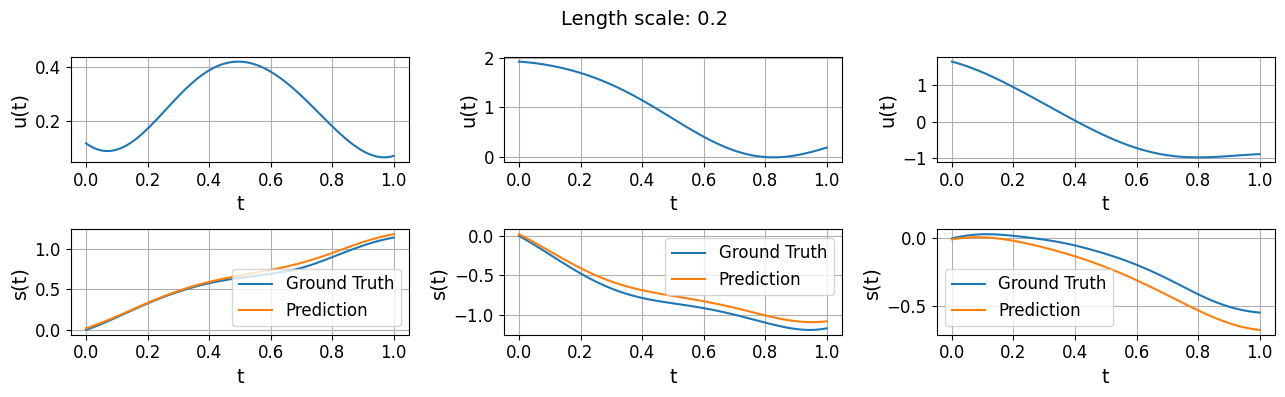

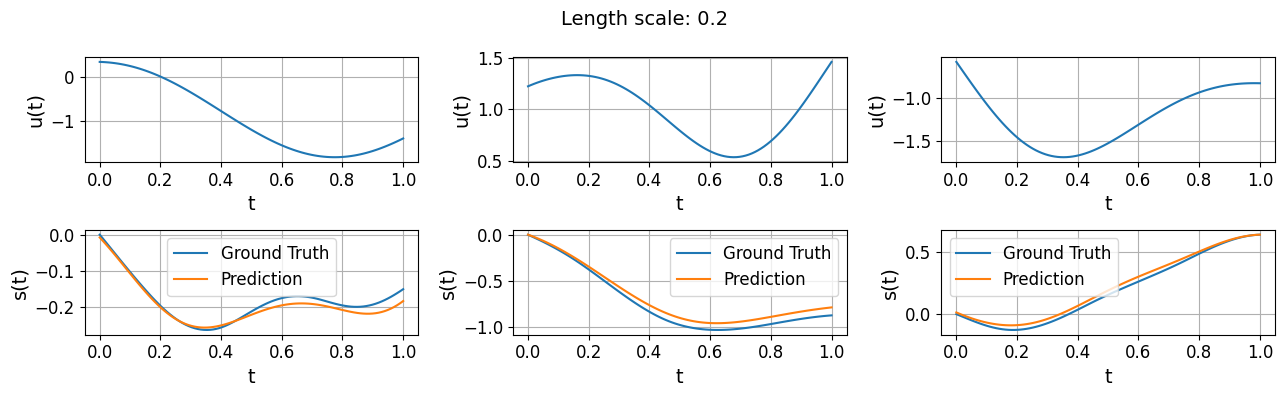

In [ ]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

In [ ]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)

    # Make prediction
    pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|██████████| 100/100 [00:00<00:00, 212.62it/s]


1/1 [==============================] - 0s 44ms/step


100%|██████████| 100/100 [00:00<00:00, 410.83it/s]


1/1 [==============================] - 0s 47ms/step


100%|██████████| 100/100 [00:00<00:00, 475.28it/s]


1/1 [==============================] - 0s 50ms/step


100%|██████████| 100/100 [00:00<00:00, 408.86it/s]


1/1 [==============================] - 0s 43ms/step


100%|██████████| 100/100 [00:00<00:00, 525.57it/s]


1/1 [==============================] - 0s 43ms/step


100%|██████████| 100/100 [00:00<00:00, 505.63it/s]

1/1 [==============================] - 0s 42ms/step



100%|██████████| 100/100 [00:00<00:00, 559.66it/s]


1/1 [==============================] - 0s 41ms/step


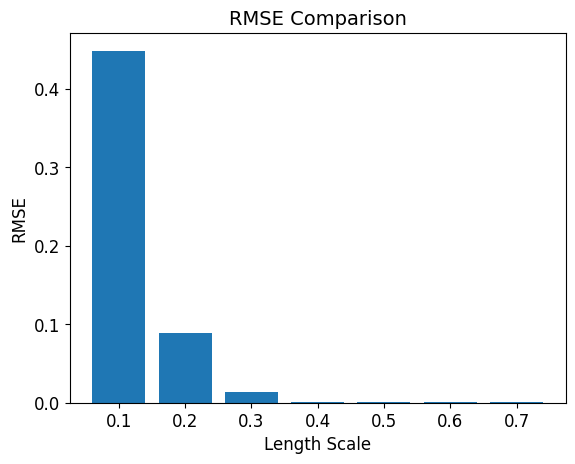

In [ ]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)